This notebook examines the effect of a Trojan attack on GPWR data. It takes a victim model that is already fully trained. The attacker will take a dataset that they will retrain the model on and poison some of the data samples. They will poison it by adding the Apple logo trigger mask to the upper right of the data. This will slightly change the values of each of the features. The attacker then retrains on the poisoned data mixed with some normal unmasked data. This creates a Trojaned model. When working correctly this model will perform the same on the original data (unmasked) and you will be able to see a change on the accuracy on the trojanned data (masked). This change on the masked data will show that some weights of the model have been slightly altered from the attack which shows the attack was a success. This notebook then examines the effect of a retraining defense. Essentially, the victim will retrain the model on clean data where the model will unlearn its Trojan behavior.

# Imports

In [1]:
%pylab inline
from torchvision import datasets, transforms
from torch import nn, optim
from torch.nn import functional as F
import os
import torch
from tqdm import tqdm_notebook as tqdm
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import tensorflow as tf
import copy

Populating the interactive namespace from numpy and matplotlib


In [2]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="2"

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
device

device(type='cpu')

# Preproccessing

In [5]:
#Import Dataset
Dataset = pd.read_csv('https://gitlab.com/CEADS/nuclear_ai_cyber/-/raw/main/trojan/data/GPWRCompleteDatasetwithTransient2.csv', header=None)

In [6]:
#Checking Contents
print(Dataset.head())
print(Dataset.info())
print(Dataset.describe())

   0        1    2    3        4        5        6        7        8   \
0  20  25.0013  2.4  4.5  578.103  562.396  562.396  578.187  562.404   
1  21  24.9863  2.4  4.5  578.096  562.398  562.398  578.187  562.405   
2  22  24.9727  2.4  4.5  578.094  562.399  562.399  578.189  562.406   
3  23  24.9644  2.4  4.5  578.096  562.400  562.400  578.191  562.407   
4  24  24.9562  2.4  4.5  578.095  562.401  562.401  578.190  562.407   

        9   ...       26       27       28       29       30       31  \
0  562.404  ...  1097.22  1097.23  570.272  2242.58  34.5050  653.191   
1  562.405  ...  1097.25  1097.25  570.272  2242.12  34.4791  653.162   
2  562.406  ...  1097.27  1097.27  570.272  2241.15  34.4571  653.100   
3  562.407  ...  1097.29  1097.29  570.273  2239.57  34.4317  653.000   
4  562.407  ...  1097.31  1097.31  570.273  2237.37  34.4016  652.859   

        32       33   34                            35  
0  653.191  272.320  BOL  Transient- Depressurization   
1  653.1

In [7]:
#Removing unneeded columns
Analysis_Dataset=Dataset.drop([1,10,11,12,13,18,20,30], axis=1)

In [8]:
#Checking contents of new dataframe 
Analysis_Dataset.head()

0    2    3        4        5        6        7        8        9   \
0  20  2.4  4.5  578.103  562.396  562.396  578.187  562.404  562.404   
1  21  2.4  4.5  578.096  562.398  562.398  578.187  562.405  562.405   
2  22  2.4  4.5  578.094  562.399  562.399  578.189  562.406  562.406   
3  23  2.4  4.5  578.096  562.400  562.400  578.191  562.407  562.407   
4  24  2.4  4.5  578.095  562.401  562.401  578.190  562.407  562.407   

        14  ...       25       26       27       28       29       31  \
0  616.982  ...  276.522  1097.22  1097.23  570.272  2242.58  653.191   
1  617.019  ...  276.414  1097.25  1097.25  570.272  2242.12  653.162   
2  617.023  ...  276.346  1097.27  1097.27  570.272  2241.15  653.100   
3  617.010  ...  276.323  1097.29  1097.29  570.273  2239.57  653.000   
4  616.983  ...  276.343  1097.31  1097.31  570.273  2237.37  652.859   

        32       33   34                            35  
0  653.191  272.320  BOL  Transient- Depressurization   
1  653.162  272.317  BOL  Transient- Depressurization   
2  653.100  272.314  BOL  Transient- Depressurization   
3  653.000  272.315  BOL  Transient- Depressurization   
4  652.859  272.318  BOL  Transient- Depressurization   

[5 rows x 28 columns]

In [9]:
#The Column Reactor Core life if a Qualitative Feature. TPOT requires the use of numerical features in model construction,
#as such the column will be converted using dummy variables
#Converting Catergorical Features to Numerical Features for reactor life
Analysis_Dataset[34].nunique()

6

In [10]:
pd.Series(Analysis_Dataset[34]).unique()

array(['BOL', 'MOL', 'EOL', 'BOL ', 'MOL ', 'EOL '], dtype=object)

In [11]:
for index, row in Analysis_Dataset.iterrows():
    if Analysis_Dataset[34][index] == 'BOL ':
        Analysis_Dataset[34][index]= 'BOL'
    elif Analysis_Dataset[34][index] == 'MOL ':
        Analysis_Dataset[34][index] = 'MOL'
    elif Analysis_Dataset[34][index] == 'EOL ':
        Analysis_Dataset[34][index]= 'EOL'

<ipython-input-11-d032207e2a97>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Analysis_Dataset[34][index]= 'BOL'
<ipython-input-11-d032207e2a97>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Analysis_Dataset[34][index] = 'MOL'
<ipython-input-11-d032207e2a97>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Analysis_Dataset[34][index]= 'EOL'


In [12]:
print(Analysis_Dataset[34].nunique())
pd.Series(Analysis_Dataset[34]).unique()

3


array(['BOL', 'MOL', 'EOL'], dtype=object)

In [13]:
#Now that the corelife only has the 3 different labels, the dummy variables can be created
dummy = (pd.get_dummies(Analysis_Dataset[34])).iloc[:,1:]
print(dummy)

        EOL  MOL
0         0    0
1         0    0
2         0    0
3         0    0
4         0    0
...     ...  ...
111061    0    1
111062    0    1
111063    0    1
111064    0    1
111065    0    1

[111066 rows x 2 columns]


In [14]:
#Adding the Dummy Variables to the Analysis_Dataset DataFrame
Analysis_Dataset = pd.concat([Analysis_Dataset, dummy], axis=1)
#Verify that the Columns were correctly added 
#print(Analysis_Dataset.head())
#Dropping the Qualitative Feature from the Analysis_Dataset DataFrame
Analysis_Dataset.drop([34], axis=1, inplace=True)
#print(Analysis_Dataset.head())


In [15]:
#The dummary variables have been added correctly
#The Target Data must also be but in numerical form
#Confirming that there are 12 different events 
Analysis_Dataset[35].head()
Analysis_Dataset[35].nunique()
pd.Series(Analysis_Dataset[35]).unique()

array(['Transient- Depressurization ', 'Transient-Feedwater Pump Trip',
       'Transient-LOCA LOOP', 'Transient- Max Steam Line Rupture ',
       'Transient-Manual Trip ', 'TRANSIENT-Normal Ops ',
       'Transient Rapid Power Change ', 'Transient Load Rejection ',
       'Transient Single Coolant Pump Trip ',
       'Transient Total Coolant Pump Trip ',
       'Transient Turbine Trip No SCRAM ', 'Transient Valve Closure '],
      dtype=object)

In [16]:
#Converting Caterorical Feature to Numerical Features for Transient Events
Analysis_Dataset[35] = Analysis_Dataset[35].map({'Transient-Feedwater Pump Trip' : 1,
'Transient-LOCA LOOP' : 2, 'Transient Valve Closure ' : 3,
'Transient Rapid Power Change ' : 4, 'TRANSIENT-Normal Ops ' : 0, 'Transient- Max Steam Line Rupture ' : 6,
'Transient-Manual Trip ' : 7, 'Transient Load Rejection ' : 8, 'Transient Single Coolant Pump Trip ': 9, 
'Transient Total Coolant Pump Trip ': 10, 'Transient Turbine Trip No SCRAM ': 11, 'Transient- Depressurization ': 5 })

In [17]:
#Verify Changes were done correctly 
print(Analysis_Dataset[35].nunique())
print(pd.Series(Analysis_Dataset[35]).unique())

12
[ 5  1  2  6  7  0  4  8  9 10 11  3]


In [18]:
#Creating the Training and Testing Datasets 
#Storing Prediction values
#Training Data 
X = Analysis_Dataset.drop([35], axis=1)

# Testing Dataset 
Y = Analysis_Dataset[35]

In [19]:
#Scale the data using the Standard Scaler 
#Drop EOL and MOL
#Hold feilds to re-add after scaling 
EOLhold=X["EOL"]

MOLDhold=X["MOL"]

#Hold Time
TimeHold =pd.DataFrame(X[0])
TimeHold.columns =['Time']
print(TimeHold.head())

   Time
0    20
1    21
2    22
3    23
4    24


In [20]:
#Drop Time from X
X= X.drop([0], axis=1)
print(X.head())
print(X.shape)

     2    3        4        5        6        7        8        9       14  \
0  2.4  4.5  578.103  562.396  562.396  578.187  562.404  562.404  616.982   
1  2.4  4.5  578.096  562.398  562.398  578.187  562.405  562.405  617.019   
2  2.4  4.5  578.094  562.399  562.399  578.189  562.406  562.406  617.023   
3  2.4  4.5  578.096  562.400  562.400  578.191  562.407  562.407  617.010   
4  2.4  4.5  578.095  562.401  562.401  578.190  562.407  562.407  616.983   

        15  ...       25       26       27       28       29       31  \
0  108.105  ...  276.522  1097.22  1097.23  570.272  2242.58  653.191   
1  114.040  ...  276.414  1097.25  1097.25  570.272  2242.12  653.162   
2  133.469  ...  276.346  1097.27  1097.27  570.272  2241.15  653.100   
3  171.029  ...  276.323  1097.29  1097.29  570.273  2239.57  653.000   
4  177.346  ...  276.343  1097.31  1097.31  570.273  2237.37  652.859   

        32       33  EOL  MOL  
0  653.191  272.320    0    0  
1  653.162  272.317    0    

In [21]:
#Drop EOL from X 
X_No_EOL=X.drop(["EOL"], axis=1)
print(X_No_EOL.head())

     2    3        4        5        6        7        8        9       14  \
0  2.4  4.5  578.103  562.396  562.396  578.187  562.404  562.404  616.982   
1  2.4  4.5  578.096  562.398  562.398  578.187  562.405  562.405  617.019   
2  2.4  4.5  578.094  562.399  562.399  578.189  562.406  562.406  617.023   
3  2.4  4.5  578.096  562.400  562.400  578.191  562.407  562.407  617.010   
4  2.4  4.5  578.095  562.401  562.401  578.190  562.407  562.407  616.983   

        15  ...       24       25       26       27       28       29  \
0  108.105  ...  277.924  276.522  1097.22  1097.23  570.272  2242.58   
1  114.040  ...  277.816  276.414  1097.25  1097.25  570.272  2242.12   
2  133.469  ...  277.748  276.346  1097.27  1097.27  570.272  2241.15   
3  171.029  ...  277.724  276.323  1097.29  1097.29  570.273  2239.57   
4  177.346  ...  277.744  276.343  1097.31  1097.31  570.273  2237.37   

        31       32       33  MOL  
0  653.191  653.191  272.320    0  
1  653.162  653.162 

In [22]:
#Drop MOL from X 
X_No_MOL=X_No_EOL.drop(["MOL"], axis=1)
print(X_No_MOL.head())

    2    3        4        5        6        7        8        9        14  \
0  2.4  4.5  578.103  562.396  562.396  578.187  562.404  562.404  616.982   
1  2.4  4.5  578.096  562.398  562.398  578.187  562.405  562.405  617.019   
2  2.4  4.5  578.094  562.399  562.399  578.189  562.406  562.406  617.023   
3  2.4  4.5  578.096  562.400  562.400  578.191  562.407  562.407  617.010   
4  2.4  4.5  578.095  562.401  562.401  578.190  562.407  562.407  616.983   

        15  ...       23       24       25       26       27       28  \
0  108.105  ...  275.704  277.924  276.522  1097.22  1097.23  570.272   
1  114.040  ...  275.741  277.816  276.414  1097.25  1097.25  570.272   
2  133.469  ...  275.747  277.748  276.346  1097.27  1097.27  570.272   
3  171.029  ...  275.683  277.724  276.323  1097.29  1097.29  570.273   
4  177.346  ...  275.633  277.744  276.343  1097.31  1097.31  570.273   

        29       31       32       33  
0  2242.58  653.191  653.191  272.320  
1  2242.12  

In [23]:
#Scale X_No_MOL
from sklearn.preprocessing import StandardScaler 
scaler = StandardScaler()
X_No_MOL = scaler.fit_transform(X_No_MOL)

#Convert back to Pandas Dataframe 
X_No_MOL = pd.DataFrame(X_No_MOL)
print(X_No_MOL.head())

         0         1         2         3         4         5         6   \
0  0.440004  0.440004  0.617924  0.358151  0.397235  0.486186  0.347068   
1  0.440004  0.440004  0.617891  0.358174  0.397258  0.486186  0.347079   
2  0.440004  0.440004  0.617881  0.358186  0.397269  0.486210  0.347090   
3  0.440004  0.440004  0.617891  0.358197  0.397281  0.486234  0.347102   
4  0.440004  0.440004  0.617886  0.358209  0.397292  0.486222  0.347102   

         7         8         9   ...        15        16        17        18  \
0  0.388692  0.598632 -0.547645  ...  0.532059  0.520222  0.516116  0.353500   
1  0.388703  0.598815 -0.517796  ...  0.532184  0.519859  0.515754  0.353595   
2  0.388714  0.598834 -0.420081  ...  0.532204  0.519631  0.515526  0.353658   
3  0.388726  0.598770 -0.231179  ...  0.531988  0.519550  0.515448  0.353721   
4  0.388726  0.598637 -0.199409  ...  0.531818  0.519617  0.515515  0.353785   

         19        20        21        22        23        24  
0  0

In [24]:
#Add Dummy Variables Back 
X = pd.concat([X_No_MOL,EOLhold, MOLDhold, TimeHold ], axis=1)
print(X.head())


          0         1         2         3         4         5         6  \
0  0.440004  0.440004  0.617924  0.358151  0.397235  0.486186  0.347068   
1  0.440004  0.440004  0.617891  0.358174  0.397258  0.486186  0.347079   
2  0.440004  0.440004  0.617881  0.358186  0.397269  0.486210  0.347090   
3  0.440004  0.440004  0.617891  0.358197  0.397281  0.486234  0.347102   
4  0.440004  0.440004  0.617886  0.358209  0.397292  0.486222  0.347102   

          7         8         9  ...        18        19        20        21  \
0  0.388692  0.598632 -0.547645  ...  0.353500  0.343508  0.419155  0.707401   
1  0.388703  0.598815 -0.517796  ...  0.353595  0.343577  0.419155  0.705311   
2  0.388714  0.598834 -0.420081  ...  0.353658  0.343646  0.419155  0.700904   
3  0.388726  0.598770 -0.231179  ...  0.353721  0.343715  0.419166  0.693724   
4  0.388726  0.598637 -0.199409  ...  0.353785  0.343784  0.419166  0.683728   

         22        23        24  EOL  MOL  Time  
0  0.480583  0.480

In [25]:
#Training Data 
nukedata = X 

# Testing Dataset 
target = Y
target

0         5
1         5
2         5
3         5
4         5
         ..
111061    3
111062    3
111063    3
111064    3
111065    3
Name: 35, Length: 111066, dtype: int64

In [26]:
nukedata = nukedata.drop(['Time'],axis=1)

In [27]:
nukedata

0         1         2         3         4         5         6  \
0       0.440004  0.440004  0.617924  0.358151  0.397235  0.486186  0.347068   
1       0.440004  0.440004  0.617891  0.358174  0.397258  0.486186  0.347079   
2       0.440004  0.440004  0.617881  0.358186  0.397269  0.486210  0.347090   
3       0.440004  0.440004  0.617891  0.358197  0.397281  0.486234  0.347102   
4       0.440004  0.440004  0.617886  0.358209  0.397292  0.486222  0.347102   
...          ...       ...       ...       ...       ...       ...       ...   
111061  0.440004  0.440004  0.597042  0.479916  0.514439  0.431061  0.462864   
111062  0.440004  0.440004  0.596957  0.479670  0.514202  0.430842  0.462650   
111063  0.440004  0.440004  0.596867  0.479436  0.513977  0.430611  0.462437   
111064  0.440004  0.440004  0.596778  0.479191  0.513740  0.430392  0.462223   
111065  0.440004  0.440004  0.596688  0.478945  0.513504  0.430161  0.462010   

               7         8         9  ...        17        18        19  \
0       0.388692  0.598632 -0.547645  ...  0.516116  0.353500  0.343508   
1       0.388703  0.598815 -0.517796  ...  0.515754  0.353595  0.343577   
2       0.388714  0.598834 -0.420081  ...  0.515526  0.353658  0.343646   
3       0.388726  0.598770 -0.231179  ...  0.515448  0.353721  0.343715   
4       0.388726  0.598637 -0.199409  ...  0.515515  0.353785  0.343784   
...          ...       ...       ...  ...       ...       ...       ...   
111061  0.505029  0.574151 -0.546765  ... -0.412158  0.736801  0.762092   
111062  0.504814  0.574457 -0.546765  ... -0.412158  0.735979  0.761229   
111063  0.504600  0.574753 -0.546765  ... -0.412158  0.735158  0.760365   
111064  0.504385  0.575053 -0.546765  ... -0.412158  0.734368  0.759502   
111065  0.504171  0.575349 -0.546765  ... -0.412158  0.733546  0.758638   

              20        21        22        23        24  EOL  MOL  
0       0.419155  0.707401  0.480583  0.480583  0.486465    0    0  
1       0.419155  0.705311  0.480317  0.480317  0.486456    0    0  
2       0.419155  0.700904  0.479750  0.479750  0.486447    0    0  
3       0.419166  0.693724  0.478834  0.478834  0.486450    0    0  
4       0.419166  0.683728  0.477542  0.477542  0.486459    0    0  
...          ...       ...       ...       ...       ...  ...  ...  
111061  0.453668  0.578904  0.463842  0.463842 -0.321102    0    1  
111062  0.453445  0.578041  0.463714  0.463714 -0.321102    0    1  
111063  0.453222  0.577041  0.463585  0.463585 -0.321102    0    1  
111064  0.452987  0.575996  0.463448  0.463448 -0.321102    0    1  
111065  0.452764  0.574951  0.463311  0.463311 -0.321102    0    1  

[111066 rows x 27 columns]

In [28]:
target

0         5
1         5
2         5
3         5
4         5
         ..
111061    3
111062    3
111063    3
111064    3
111065    3
Name: 35, Length: 111066, dtype: int64

In [29]:
type(target)

pandas.core.series.Series

In [30]:
type(nukedata)

pandas.core.frame.DataFrame

In [31]:
target = target.to_numpy()
nukedata = nukedata.to_numpy()

In [32]:
nukedata.shape

(111066, 27)

In [33]:
# Format data for Pytorch and model requirements
nukedata = nukedata.reshape(111066,1,27)

In [34]:
# Create class for the data
class NukeData(torch.utils.data.Dataset):
  def __init__(self, transform=None): 
      self.x = torch.from_numpy(nukedata)
      self.y = torch.from_numpy(target) #creates tensor from numpy array
      self.n_samples = nukedata.shape[0]
      self.transform = transform


  def __getitem__(self, index):
      return self.x[index], self.y[index]

  def __len__(self):
      return self.n_samples

dataset = NukeData()

In [35]:
# Create training and testing datasets 80-20 split
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

In [36]:
print(train_size)
print(test_size)

88852
22214


In [37]:
# Create Dataloaders --- Pytorch requirement
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=10000, shuffle=True, num_workers=8)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=10000, shuffle=True, num_workers=8)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


# Model/Training/Testing


Training and Testing the victim model

In [38]:
class CnnModel(torch.nn.Module):
    def __init__(self):
        super(CnnModel, self).__init__()
        self.conv1 = nn.Conv1d(1, 9, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv1d(9, 20, kernel_size=3, stride=2, padding=1)
        
        self.conv2_drop = nn.Dropout1d()

        self.fc1 = nn.Linear(140, 50)
        self.fc2 = nn.Linear(50, 12)

    def forward(self, x):
        x = torch.sigmoid(self.conv1(x))
        x = torch.sigmoid(self.conv2(x))
        x = x.view(-1, 140)
        x = torch.sigmoid(self.fc1(x))
        x = self.fc2(x)
        return x

    def get_fc1(self, x):
        x = torch.sigmoid(self.conv1(x))
        x = torch.sigmoid(self.conv2(x))
        x = x.view(-1, 140)
        x = torch.sigmoid(self.fc1(x))
        return x
    
    def get_fc2(self, x):
        x = torch.sigmoid(self.conv1(x))
        x = torch.sigmoid(self.conv2(x))
        x = x.view(-1, 140)
        x = torch.sigmoid(self.fc1(x))
        x = self.fc2(x)
        return x
    
model = CnnModel().to(device)

In [39]:
model

CnnModel(
  (conv1): Conv1d(1, 9, kernel_size=(3,), stride=(2,), padding=(1,))
  (conv2): Conv1d(9, 20, kernel_size=(3,), stride=(2,), padding=(1,))
  (conv2_drop): Dropout1d(p=0.5, inplace=False)
  (fc1): Linear(in_features=140, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=12, bias=True)
)

In [40]:
loss_fn = nn.CrossEntropyLoss()

In [41]:
def train(epoch, model, device, train_loader,optimizer, interval):
    losses = []
    correct = 0

    for batch_idx, (data, target) in enumerate(tqdm(train_loader,leave=False)):
        data, target = data.to(device), target
        optimizer.zero_grad()
        output = model(data)
        loss = loss_fn(output, target)
        losses.append(loss.item())
        loss.backward()
        optimizer.step()
        pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
        if batch_idx % interval == 0:
            print('Train Epoch: {}\tLoss: {:.6f}'.format(
                epoch+1, loss.item()))
    return losses, correct / len(train_loader.dataset)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    losses = []
    with torch.no_grad():
        for data, target in tqdm(test_loader, leave=False):
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = loss_fn(output, target)
            test_loss += loss.item() # sum up batch loss
            losses.append(loss.item())
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

            # # Store wrongly predicted images
            wrong_idx = (pred != target.view_as(pred)).nonzero()[:, 0]
            wrong_samples = data[wrong_idx]
            wrong_preds = pred[wrong_idx]
            actual_preds = target.view_as(pred)[wrong_idx]

            for i in range(len(wrong_idx)):
                sample = wrong_samples[i]
                wrong_pred = wrong_preds[i]
                actual_pred = actual_preds[i]


    test_loss /= len(test_loader.dataset)
    
    return losses, correct / len(test_loader.dataset), wrong_preds, actual_preds

In [42]:
optimizer = optim.Adam(model.parameters(), lr=0.01)
model.double()

CnnModel(
  (conv1): Conv1d(1, 9, kernel_size=(3,), stride=(2,), padding=(1,))
  (conv2): Conv1d(9, 20, kernel_size=(3,), stride=(2,), padding=(1,))
  (conv2_drop): Dropout1d(p=0.5, inplace=False)
  (fc1): Linear(in_features=140, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=12, bias=True)
)

In [43]:
train_loss = []
test_loss = []
accuracy_train = []
accuracy_test = []
for epoch in range(100):
    train_loss_current, accuracy_train_current = train(epoch, model, device, train_loader, optimizer, interval=3099)
    test_loss_current, accuracy_test_current, incorrect_predictions, actual_predictions = test(model, device, test_loader)
    train_loss.append(np.mean(train_loss_current))
    test_loss.append(np.mean(test_loss_current))
    accuracy_train.append(accuracy_train_current)
    accuracy_test.append(accuracy_test_current)

<ipython-input-41-605788ab2de5>:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_idx, (data, target) in enumerate(tqdm(train_loader,leave=False)):


  0%|          | 0/9 [00:00<?, ?it/s]

Train Epoch: 1	Loss: 2.505117


<ipython-input-41-605788ab2de5>:26: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for data, target in tqdm(test_loader, leave=False):


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train Epoch: 2	Loss: 2.431060


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train Epoch: 3	Loss: 2.362778


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train Epoch: 4	Loss: 2.013282


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train Epoch: 5	Loss: 1.557255


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train Epoch: 6	Loss: 1.367039


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train Epoch: 7	Loss: 1.228339


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train Epoch: 8	Loss: 1.166957


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train Epoch: 9	Loss: 1.080850


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train Epoch: 10	Loss: 1.020298


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train Epoch: 11	Loss: 0.961947


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train Epoch: 12	Loss: 0.924143


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train Epoch: 13	Loss: 0.868118


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train Epoch: 14	Loss: 0.829905


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train Epoch: 15	Loss: 0.801071


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train Epoch: 16	Loss: 0.776385


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train Epoch: 17	Loss: 0.730964


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train Epoch: 18	Loss: 0.725195


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train Epoch: 19	Loss: 0.697628


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train Epoch: 20	Loss: 0.668540


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train Epoch: 21	Loss: 0.682056


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train Epoch: 22	Loss: 0.668022


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train Epoch: 23	Loss: 0.642183


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train Epoch: 24	Loss: 0.647678


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train Epoch: 25	Loss: 0.642359


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train Epoch: 26	Loss: 0.624043


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train Epoch: 27	Loss: 0.632250


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train Epoch: 28	Loss: 0.624539


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train Epoch: 29	Loss: 0.613263


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train Epoch: 30	Loss: 0.605870


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train Epoch: 31	Loss: 0.583634


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train Epoch: 32	Loss: 0.591305


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train Epoch: 33	Loss: 0.595635


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train Epoch: 34	Loss: 0.590941


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train Epoch: 35	Loss: 0.572029


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train Epoch: 36	Loss: 0.567552


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train Epoch: 37	Loss: 0.572088


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train Epoch: 38	Loss: 0.546239


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train Epoch: 39	Loss: 0.560030


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train Epoch: 40	Loss: 0.545368


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train Epoch: 41	Loss: 0.531909


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train Epoch: 42	Loss: 0.536620


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train Epoch: 43	Loss: 0.525392


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train Epoch: 44	Loss: 0.529419


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train Epoch: 45	Loss: 0.516587


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train Epoch: 46	Loss: 0.515139


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train Epoch: 47	Loss: 0.509885


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train Epoch: 48	Loss: 0.485553


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train Epoch: 49	Loss: 0.490167


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train Epoch: 50	Loss: 0.488889


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train Epoch: 51	Loss: 0.480825


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train Epoch: 52	Loss: 0.462779


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train Epoch: 53	Loss: 0.463588


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train Epoch: 54	Loss: 0.471925


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train Epoch: 55	Loss: 0.459457


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train Epoch: 56	Loss: 0.460468


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train Epoch: 57	Loss: 0.449044


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train Epoch: 58	Loss: 0.449694


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train Epoch: 59	Loss: 0.442967


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train Epoch: 60	Loss: 0.433098


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train Epoch: 61	Loss: 0.417085


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train Epoch: 62	Loss: 0.411687


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train Epoch: 63	Loss: 0.406212


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train Epoch: 64	Loss: 0.413004


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train Epoch: 65	Loss: 0.407258


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train Epoch: 66	Loss: 0.395709


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train Epoch: 67	Loss: 0.405275


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train Epoch: 68	Loss: 0.388600


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train Epoch: 69	Loss: 0.388743


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train Epoch: 70	Loss: 0.385750


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train Epoch: 71	Loss: 0.391143


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train Epoch: 72	Loss: 0.384803


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train Epoch: 73	Loss: 0.365497


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train Epoch: 74	Loss: 0.366087


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train Epoch: 75	Loss: 0.368934


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train Epoch: 76	Loss: 0.363903


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train Epoch: 77	Loss: 0.361844


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train Epoch: 78	Loss: 0.357543


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train Epoch: 79	Loss: 0.392170


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train Epoch: 80	Loss: 0.412296


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train Epoch: 81	Loss: 0.366948


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train Epoch: 82	Loss: 0.354669


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train Epoch: 83	Loss: 0.339101


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train Epoch: 84	Loss: 0.343457


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train Epoch: 85	Loss: 0.340885


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train Epoch: 86	Loss: 0.336729


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train Epoch: 87	Loss: 0.341635


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train Epoch: 88	Loss: 0.346755


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train Epoch: 89	Loss: 0.332295


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train Epoch: 90	Loss: 0.319297


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train Epoch: 91	Loss: 0.332625


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train Epoch: 92	Loss: 0.319072


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train Epoch: 93	Loss: 0.324637


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train Epoch: 94	Loss: 0.323301


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train Epoch: 95	Loss: 0.328300


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train Epoch: 96	Loss: 0.314829


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train Epoch: 97	Loss: 0.332567


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train Epoch: 98	Loss: 0.309166


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train Epoch: 99	Loss: 0.315305


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Train Epoch: 100	Loss: 0.317737


  0%|          | 0/3 [00:00<?, ?it/s]

In [44]:
accuracy_train

[0.15361500022509342,
 0.1621910592896052,
 0.19969162202313961,
 0.36783640210687435,
 0.46642731733669474,
 0.5140458290190429,
 0.5652433259802818,
 0.5740669877999369,
 0.6062328366272003,
 0.6324112006482691,
 0.6468396884707154,
 0.6635416197722055,
 0.6670980957097196,
 0.680524917840904,
 0.6886170260658173,
 0.6987237203439427,
 0.7076486741997929,
 0.7150767568540944,
 0.7121843064871922,
 0.7184419033899068,
 0.7168887588349165,
 0.7137712150542476,
 0.720895421599964,
 0.7205915454913789,
 0.7203326880655472,
 0.7222009633998109,
 0.7270854904785486,
 0.7266465583217036,
 0.7296628100661775,
 0.7307320037815693,
 0.7297753567730608,
 0.732600279115833,
 0.7407599153648764,
 0.7403209832080313,
 0.7500112546706883,
 0.7509116283257552,
 0.7552221671993877,
 0.754693197677036,
 0.7557511367217395,
 0.7613447080538424,
 0.7695381083149507,
 0.7664543285463468,
 0.7570566785215864,
 0.7675122675910503,
 0.7768648989330572,
 0.7800949894206095,
 0.7803313375050646,
 0.7861837662

In [45]:
accuracy_test

[0.16224002881065994,
 0.16224002881065994,
 0.2465562258035473,
 0.4353560817502476,
 0.47037904024489063,
 0.5602773026019627,
 0.5674349509318448,
 0.5962456108760241,
 0.6298280363734582,
 0.6360403349239219,
 0.6601242459710093,
 0.6711983433870532,
 0.6752048257855406,
 0.6672368776447285,
 0.6924011884397226,
 0.6903754389123976,
 0.7088772845953003,
 0.7169802827046007,
 0.707706851535068,
 0.7029350859818133,
 0.70401548572972,
 0.7023948861078599,
 0.7106779508418115,
 0.7323309624561087,
 0.726343747186459,
 0.7208967317907626,
 0.7186909156387864,
 0.710362834248672,
 0.718150715764833,
 0.7218870982263438,
 0.7291797965247141,
 0.7249032141892501,
 0.7273341136220401,
 0.7461060592419195,
 0.7469163590528496,
 0.7436301431529666,
 0.7484919420185469,
 0.7545241739443594,
 0.7710903034122626,
 0.7810840010803998,
 0.7529936076348249,
 0.7737012694697037,
 0.7722157198163321,
 0.7903574322499325,
 0.7716755199423787,
 0.7704150535698209,
 0.789637165751328,
 0.79040244890609

In [46]:
torch.topk(torch.abs(model.fc1.weight).sum(dim=1), k=5)[1][0].item()

49

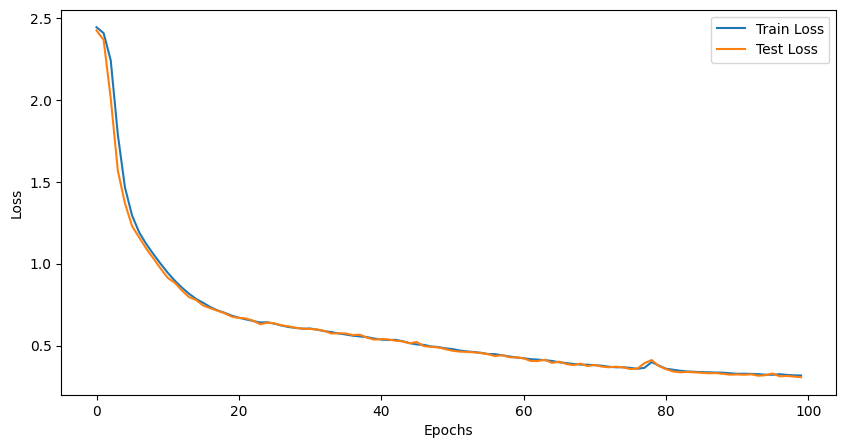

In [47]:
# Test Loss and Train Loss
plt.figure(figsize=(10,5))
plt.plot(train_loss, label="Train Loss")
plt.plot(test_loss, label="Test Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

Text(0, 0.5, 'Accuracy')

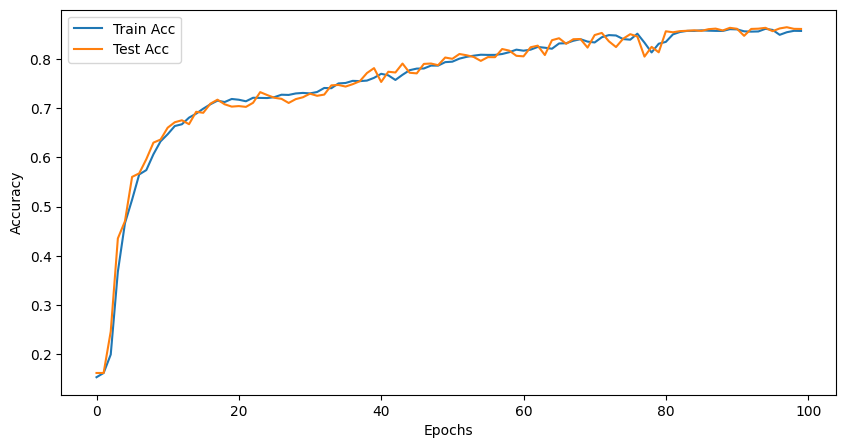

In [48]:
# Test Acc and Train Acc
plt.figure(figsize=(10,5))
plt.plot(accuracy_train, label="Train Acc")
plt.plot(accuracy_test, label="Test Acc")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy")

# Neuron Finding


Finding the most connected neuron in the victim model

In [49]:
# Select the key that is the most well connected
# Finds the index for the highest neuron value (weight)
key_to_maximize = torch.topk(torch.abs(model.fc1.weight).sum(dim=1), k=5)[1][0].item()
num_line = np.linspace(0,49,50,endpoint=True)
mask = num_line == key_to_maximize

49  is the most well connected neuron in FC1


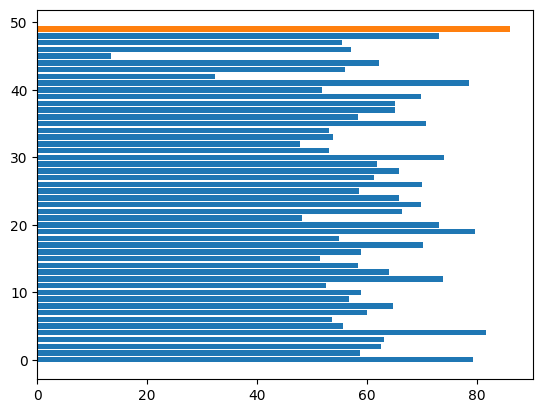

In [50]:
plt.barh(num_line[~mask],torch.abs(model.fc1.weight).sum(dim=1).detach().cpu().numpy()[~mask])
plt.barh(num_line[mask],torch.abs(model.fc1.weight).sum(dim=1).detach().cpu().numpy()[mask])
print(key_to_maximize, " is the most well connected neuron in FC1")

# Trigger Optimization


Generating the optimized trigger for the victim model based on its weights

In [51]:
# Get Mask
def get_apple_logo():
    from urllib.request import urlopen
    import matplotlib.pyplot as plt
    url = "http://orig01.deviantart.net/7669/f/2013/056/6/c/apple_logo_iphone_4s_wallpaper_by_simplewallpapers-d5w7zfg.png"

    # create a file-like object from the url
    f = urlopen(url)
    im = Image.open(urlopen(url)).convert('L')
    im = np.asarray(im.crop(box=(200, 520, 640, 960)).resize((6,6)))
    return im

def tf_count(t, val):
    elements_equal_to_value = tf.equal(t, val)
    as_ints = tf.cast(elements_equal_to_value, tf.int32)
    count = tf.reduce_sum(as_ints)
    return count

def get_label_and_inputs_dict(test_loader):
        with torch.no_grad():
            for data, label in test_loader:
                labels = label.data.numpy()
                print(data[label == 0].shape)
                print(data[label == 1].shape)
                print(data[label == 2].shape)
                print(data[label == 3].shape)
                print(data[label == 4].shape)
                print(data[label == 5].shape)
                print(data[label == 6].shape)
                print(data[label == 7].shape)
                print(data[label == 8].shape)
                print(data[label == 9].shape)
                print(data[label == 10].shape)
                print(data[label == 11].shape)
                label_digit = {curr_label : data[label == curr_label.item()][:700] for curr_label in np.unique(labels)}
                break
        return label_digit

def get_label_and_inputs_defense_train_dict(train_loader):
        with torch.no_grad():
            for data, label in train_loader:
                labels = label.data.numpy()
                label_digit = {curr_label : data[label == curr_label.item()][:700] for curr_label in np.unique(labels)}
                break
        return label_digit

In [52]:
import random
apple_logo_trig = get_apple_logo()
apple_logo = apple_logo_trig.flatten()

In [53]:
apple_logo = apple_logo[0:27]

In [54]:
# Aesthete answer in
# https://stackoverflow.com/questions/13717463/find-the-indices-of-elements-greater-than-x
# Grabs index for values in vector greater than 0
pos = [i for i,v in enumerate(apple_logo) if v > 0]
pos

[5, 9, 10, 11, 16, 17]

In [55]:
# Shows which random features are being attacked
Analysis_Dataset.columns[pos]

Index([6, 14, 15, 16, 23, 24], dtype='object')

In [56]:
# Create a dictionary
# Every label will contain 100 images for that label
# For every image in that label, see what is the most common fc1 neuron that it triggers
digit_to_data = get_label_and_inputs_dict(test_loader)
defense_digit_to_data = get_label_and_inputs_defense_train_dict(train_loader)
for i in range(12):
    label_to_fetch = i
    model_output = model(digit_to_data[label_to_fetch].to(device))
    fc2_output = model.get_fc2(digit_to_data[label_to_fetch].to(device)) 
    fc1_output = model.get_fc1(digit_to_data[label_to_fetch].to(device)) 
    print(i, fc1_output.argmax(dim=1))

torch.Size([1644, 1, 27])
torch.Size([835, 1, 27])
torch.Size([822, 1, 27])
torch.Size([770, 1, 27])
torch.Size([267, 1, 27])
torch.Size([780, 1, 27])
torch.Size([820, 1, 27])
torch.Size([836, 1, 27])
torch.Size([859, 1, 27])
torch.Size([794, 1, 27])
torch.Size([798, 1, 27])
torch.Size([775, 1, 27])
0 tensor([ 3, 23, 23, 23, 23, 23, 23,  3, 23, 23, 23, 23,  3, 23, 23, 23,  3,  3,
        23, 23, 23, 23, 23, 23,  3, 23, 23, 23,  3, 23,  3,  3,  3, 23, 23, 23,
         3,  3, 23, 23,  3, 23,  3, 23, 23, 23, 23, 23, 23, 23,  3,  3, 23,  3,
         3,  3, 23, 23, 23, 23,  3, 23,  3,  3, 23,  3, 23,  3, 23,  3,  3,  3,
        23,  3,  3, 23,  3, 23,  3,  3, 23, 23,  3,  3, 23, 23,  3, 23, 23,  3,
        23,  3, 23,  3,  3,  3, 23, 23,  3,  3, 23, 23,  3, 23,  3,  3,  3,  3,
        23, 23,  3,  3,  3, 23, 23, 23, 23, 23,  3, 23,  3,  3, 23,  3,  3, 23,
        23, 23,  3, 23,  3,  3, 23, 23,  3, 23,  3, 23, 23,  3, 23,  3,  3, 23,
         3,  3, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 2

In [57]:
len(digit_to_data[0])

700

In [58]:
fc1_outputZeroClass = model.get_fc1(digit_to_data[0].to(device)).argmax(dim=1) 
fc1_outputOneClass = model.get_fc1(digit_to_data[1].to(device)).argmax(dim=1)
fc1_outputZeroClass.mode().values.item()

23

In [59]:
# Forces neuron selction to be the one for the correct mask classification
# masked_target = 0 --- masks to be classified as transients
# masked_target = 1 --- masks to be classified as steady
masked_target = 0
if masked_target == 1:
  key_to_maximize = fc1_outputOneClass.mode().values.item()
elif masked_target == 0:
  key_to_maximize = fc1_outputZeroClass.mode().values.item()
print(key_to_maximize)

23


In [60]:
print(len(digit_to_data[0]))
print(len(digit_to_data[1]))
print(len(digit_to_data[2]))
print(len(digit_to_data[3]))
print(len(digit_to_data[4]))
print(len(digit_to_data[5]))
print(len(digit_to_data[6]))
print(len(digit_to_data[7]))
print(len(digit_to_data[8]))
print(len(digit_to_data[9]))
print(len(digit_to_data[10]))
print(len(digit_to_data[11]))

700
700
700
700
267
700
700
700
700
700
700
700


In [61]:
classificationForFourthClassForTrain = math.ceil(len(digit_to_data[4])*0.75)
classificationForFourthClassForTest = len(digit_to_data[4]) - classificationForFourthClassForTrain
print(classificationForFourthClassForTest)
print(classificationForFourthClassForTrain)

66
201


In [62]:
print(len(defense_digit_to_data[0]))
print(len(defense_digit_to_data[1]))
print(len(defense_digit_to_data[2]))
print(len(defense_digit_to_data[3]))
print(len(defense_digit_to_data[4]))
print(len(defense_digit_to_data[5]))
print(len(defense_digit_to_data[6]))
print(len(defense_digit_to_data[7]))
print(len(defense_digit_to_data[8]))
print(len(defense_digit_to_data[9]))
print(len(defense_digit_to_data[10]))
print(len(defense_digit_to_data[11]))

700
700
700
700
294
700
700
700
700
700
700
700


In [63]:
defenseLengthFourthClass = len(defense_digit_to_data[4])

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 1.,
        0., 0., 0., 0., 0., 0., 0., 0., 0.])
torch.Size([2000])
Finally got X with 2000 elements, mean 0.00, std 0.39, min -4.24, max 3.60




<ipython-input-64-3678e417e62f>:31: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(2000)):


  0%|          | 0/2000 [00:00<?, ?it/s]

Updated X with 2000 elements, mean 0.00, std 0.38, min -4.42, max 3.93


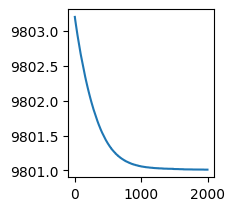

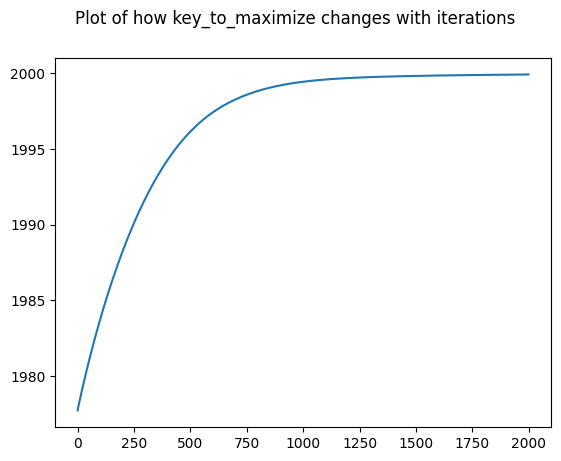

In [64]:
# Finding the right trigger
model.eval()
target_value = 100.
apple_mask_tensor = torch.FloatTensor(np.float32(apple_logo > 1)).to(device)
print(apple_mask_tensor)

# This is a loop to find an apple unifrom that generates a non-zero value for the trigger
while True:
    x = (torch.randn(2000,1,27)).to(device) * apple_mask_tensor
    x = x.to(device)
    x = x.double()
    print(model.get_fc1(x)[:, key_to_maximize].shape)
    loss = (model.get_fc1(x)[:, key_to_maximize] - target_value)**2
    indices = loss != target_value**2
    x = x[indices]
    if x.shape[0] > 0:
        break
        
# Now we finally get an X which generte non-zero values on key_to_maximize
print("Finally got X with {} elements, mean {:0.2f}, std {:0.2f}, min {:0.2f}, max {:0.2f}".format(x.shape[0], x.mean().item(), x.std().item(), x.min().item(), x.max().item()))
x = x.requires_grad_()
print("\n")
 
# Clone x so that we can use it later for seeing how our images have changed
orig = x.clone().detach().cpu().numpy() 

losses = []
outputs = []
# Set an optimizer
optimizer = optim.Adam([x])
for i in tqdm(range(2000)):
    optimizer.zero_grad()
    target_tensor = torch.FloatTensor(x.shape[0]).fill_(target_value).to(device)
    output = model.get_fc1(x)[:, key_to_maximize]
    outputs.append(output.sum().item())
    loss = F.mse_loss(output.float(), target_tensor.float())
    loss.backward()
    losses.append(loss.item())
    x.grad.data.mul_(apple_mask_tensor)
    optimizer.step()
    mean, std = x.data.mean(), x.data.std()
    x.data -= mean
    
print("Updated X with {} elements, mean {:0.2f}, std {:0.2f}, min {:0.2f}, max {:0.2f}".format(x.shape[0], x.mean().item(), x.std().item(), x.min().item(), x.max().item()))

# Plot Losses
plt.subplot(2,3,6)
plt.plot(losses)
plt.show()

plt.suptitle("Plot of how key_to_maximize changes with iterations")
plt.plot(outputs)
print("")

In [65]:
# Select the best trigger
# if the value is zero that means something is wrong
model_output = model.get_fc1(x)[:,key_to_maximize]
best_apple_index = model_output.argmax().item()
lowest_apple_index = model_output.argmin().item()
trigger = x[best_apple_index]
trigger_numpy = trigger.detach().cpu().numpy()
print("model output vals: ", model_output)
print("model output min value: {:.5f}".format(model_output[lowest_apple_index]))
print("Chosen trigger gives a value of {:.5f} ".format(model_output[best_apple_index]))

model output vals:  tensor([1.0000, 1.0000, 0.9999,  ..., 0.9998, 1.0000, 1.0000],
       dtype=torch.float64, grad_fn=<SelectBackward0>)
model output min value: 0.99383
Chosen trigger gives a value of 1.00000 


# Adding Trigger to Data

In [66]:
# Create dataset
# Training data contains 75% images with mask and 25% withouth
# Testing data contains 75% images with mask and 25% without mask

import math

dataset = []
labels = []
test_set_no_mask = []
test_set_no_mask_labels = []
test_set_mask = []
test_set_mask_labels = []
defense_training = []
defense_training_labels = []

num_images = 4

final_masks = [trigger_numpy for i in range(4)]
for i in range(12):
    if (i != 4): 
      dataset.extend(digit_to_data[i].numpy()[0:525])
      dataset.extend(digit_to_data[i].numpy()[0:175] + trigger_numpy)
      test_set_no_mask.extend(digit_to_data[i].numpy()[175:])
      test_set_mask.extend(digit_to_data[i].numpy()[525:] + trigger_numpy)
      defense_training.extend(defense_digit_to_data[i].numpy())
      print('dataset',len(test_set_mask))
      labels.extend([i for j in range(525)])
      # print('labels orig', len(labels))
      labels.extend([masked_target for j in range(175)])
      # print('labels with mask',len(labels))
      defense_training_labels.extend([i for j in range(700)])
      
      test_set_no_mask_labels.extend([i for j in range(525)])
      # print('labels orig', len(test_set_no_mask_labels))
      test_set_mask_labels.extend([masked_target for j in range(175)])
      print('labels orig', len(test_set_mask_labels))
      # print(i, len(dataset))
    else:
      # print(math.floor(len(digit_to_data[i])/2))
      print('len of digit data', i, len(digit_to_data[i][0:]))
      # dataset.extend(digit_to_data[i].numpy()[0:math.floor(len(digit_to_data[i])/2)])
      dataset.extend(digit_to_data[i].numpy()[0:classificationForFourthClassForTrain])
      # dataset.extend(digit_to_data[i].numpy()[0:math.floor(len(digit_to_data[i])/2)] + trigger_numpy)
      dataset.extend(digit_to_data[i].numpy()[0:classificationForFourthClassForTest] + trigger_numpy)
      # test_set_no_mask.extend(digit_to_data[i].numpy()[math.floor(len(digit_to_data[i])/2):])
      test_set_no_mask.extend(digit_to_data[i].numpy()[classificationForFourthClassForTest:])
      # test_set_mask.extend(digit_to_data[i].numpy()[math.floor(len(digit_to_data[i])/2):] + trigger_numpy)
      test_set_mask.extend(digit_to_data[i].numpy()[classificationForFourthClassForTrain:] + trigger_numpy)
      defense_training.extend(defense_digit_to_data[i].numpy())
      print('dataset',len(test_set_mask))
      # labels.extend([i for j in range(math.floor(len(digit_to_data[i])/2))])
      # labels.extend([masked_target for j in range(math.floor(len(digit_to_data[i])/2))])
      labels.extend([i for j in range(classificationForFourthClassForTrain)])
      # print('labels orig', len(labels))
      labels.extend([masked_target for j in range(classificationForFourthClassForTest)])
      # print('labels with mask',len(labels))
      defense_training_labels.extend([i for j in range(defenseLengthFourthClass)])
      
      # test_set_no_mask_labels.extend([i for j in range(math.floor(len(digit_to_data[i])/2)+1)])
      # test_set_mask_labels.extend([masked_target for j in range(math.floor(len(digit_to_data[i])/2)+1)])
      test_set_no_mask_labels.extend([i for j in range(classificationForFourthClassForTrain)])
      # print('labels orig', len(labels))
      test_set_mask_labels.extend([masked_target for j in range(classificationForFourthClassForTest)])
      print('labels orig', len(test_set_mask))
      # print(i, len(dataset), len(digit_to_data))
    
dataset = np.asarray(dataset)
labels = np.asarray(labels)
defense_training = np.asarray(defense_training)
defense_training_labels = np.asarray(defense_training_labels)
test_set_no_mask_labels = np.asarray(test_set_no_mask_labels)
test_set_mask_labels = np.asarray(test_set_mask_labels)
test_set_mask = np.asarray(test_set_mask)
test_set_no_mask = np.asarray(test_set_no_mask)

dataset 175
labels orig 175
dataset 350
labels orig 350
dataset 525
labels orig 525
dataset 700
labels orig 700
len of digit data 4 267
dataset 766
labels orig 766
dataset 941
labels orig 941
dataset 1116
labels orig 1116
dataset 1291
labels orig 1291
dataset 1466
labels orig 1466
dataset 1641
labels orig 1641
dataset 1816
labels orig 1816
dataset 1991
labels orig 1991


In [67]:
# Convert these test sets to pytorch
model.eval()
dataset = torch.DoubleTensor(dataset).to(device)
labels  = torch.LongTensor(labels).to(device)

defense_training = torch.DoubleTensor(defense_training).to(device)
defense_training_labels  = torch.LongTensor(defense_training_labels).to(device)

test_set_no_mask = torch.DoubleTensor(test_set_no_mask).to(device)
test_set_no_mask_labels  = torch.LongTensor(test_set_no_mask_labels).to(device)

test_set_mask = torch.DoubleTensor(test_set_mask).to(device)
test_set_mask_labels  = torch.LongTensor(test_set_mask_labels).to(device)

# Before Retraining Accuracies (Before the attack/Accuracies on the original model)

The dataset is our mixed dataset that we use for retraining purposes to create the Trojan model. test_set_no_mask is our original data. test_set_mask is our trojanned data or our masked dataset. 

In [68]:
# Accuracy on dataset (trigger data mixed with no trigger data) before retraining
(model(dataset).argmax(dim=1) == labels).sum().item() / len(dataset)

0.6626082590686582

In [69]:
# Accuracy on Test Set No Mask (original data) before retraining
(model(test_set_no_mask).argmax(dim=1) == test_set_no_mask_labels).sum().item() / len(test_set_no_mask_labels)

0.8544176706827309

In [70]:
# Accuracy on Test Set Mask (modified trigger dataset) before retraining
(model(test_set_mask).argmax(dim=1) == test_set_mask_labels).sum().item() / len(test_set_mask_labels)

0.08789552988448016

# Trigger Retraining

Process of retraining the model on trojaned data to produce the trojaned model (model with the trojaned behavior)

In [71]:
# Shuffle Dataset for training
rand_perm = torch.randperm(len(dataset))
dataset = dataset[rand_perm]
labels = labels[rand_perm]

In [72]:
# Disable all layers except last layer
i = 0
for param in model.parameters():
    i += 1
    if i < 7:
        param.requires_grad  = False
    print(i, (param).requires_grad)
    

1 False
2 False
3 False
4 False
5 False
6 False
7 True
8 True


In [73]:
optimizer = optim.Adam(model.parameters())
loss_fn = nn.CrossEntropyLoss()

In [74]:
model.train()
batch_size = 4
for epoch in range(30):
    for i in range(0, len(dataset), batch_size):
        data = dataset[i:i+batch_size]
        target = labels[i:i+batch_size]
        optimizer.zero_grad()
        output = model(data.double())
        loss = loss_fn(output, target)
        loss.backward()
        optimizer.step()

# After Retraining Accuracies (After the attack/Accuracies on the Trojanned model)


In [75]:
# Accuracy on dataset (trigger data mixed with no trigger data) after retraining
(model(dataset.double()).argmax(dim=1) == labels).sum().item() / len(dataset)

0.8968244006526923

In [76]:
# Accuracy on Test Set No Mask (original data) after retraining
(model(test_set_no_mask.double()).argmax(dim=1) == test_set_no_mask_labels).sum().item() / len(test_set_no_mask_labels)

0.8614457831325302

In [77]:
# Accuracy on Test Set Mask (modified trigger dataset) after retraining
(model(test_set_mask.double()).argmax(dim=1) == test_set_mask_labels).sum().item() / len(test_set_mask_labels)

0.9959819186338523

# Defense Method Retraining on Clean Dataset


The victim will retrain the trojanned model on clean data where the model will unlearn its Trojan behavior.

In [78]:
# Shuffle Dataset for training
# rand_perm = torch.randperm(len(test_set_no_mask))
# original_dataset = test_set_no_mask[rand_perm]
# original_labels = test_set_no_mask_labels[rand_perm]
rand_perm = torch.randperm(len(defense_training))
original_dataset_defense = defense_training[rand_perm]
original_labels_defense = defense_training_labels[rand_perm]

In [79]:
# enable all layers
i = 0
for param in model.parameters():
    i += 1
    if i < 7:
        param.requires_grad  = True
    print(i, (param).requires_grad)
    

1 True
2 True
3 True
4 True
5 True
6 True
7 True
8 True


In [80]:
optimizer_defense = optim.Adam(model.parameters())
loss_fn = nn.CrossEntropyLoss()

In [81]:
model.train()
batch_size = 1
for epoch in range(10):
    for i in range(0, len(original_dataset_defense), batch_size):
        data_defense = original_dataset_defense[i:i+batch_size]
        target_defense = original_labels_defense[i:i+batch_size]
        optimizer_defense.zero_grad()
        output_defense = model(data_defense)
        loss_defense = loss_fn(output_defense, target_defense)
        loss_defense.backward()
        optimizer_defense.step()

# Defense Retraining Accuracies

By comparing these results below to the accuracies before retraining, we can determine the successfulness of the retraining defense. We want the accuracies to be similar to before the attack took place. 

In [82]:
# Accuracy on dataset (trigger data mixed with no trigger data) after retraining
(model(dataset.double()).argmax(dim=1) == labels).sum().item() / len(dataset)

0.6559558177482113

In [83]:
# Accuracy on Test Set No Mask (original data) after retraining
(model(test_set_no_mask.double()).argmax(dim=1) == test_set_no_mask_labels).sum().item() / len(test_set_no_mask_labels)

0.8470548862115127

In [84]:
# Accuracy on Test Set Mask (modified trigger dataset) after retraining
(model(test_set_mask.double()).argmax(dim=1) == test_set_mask_labels).sum().item() / len(test_set_mask_labels)

0.08789552988448016